In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [2]:
dataset_PT = TSD(file_path='../datasets/power_transitions.xlsx')

Dataset loaded from ../datasets/power_transitions.xlsx


In [3]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]

pt_dat = dataset_PT.raw[['PolityID', 'PolityName','Year']+crisis_vars].copy()


In [4]:
dt = 100
dataset = TSD(file_path=f'../datasets/{dt}_yr_dataset.xlsx')
dataset.scv_imputed = pd.DataFrame([])
dataset.scv['Hierarchy_sq'] = dataset.scv['Hierarchy']**2
# impute scale and non scale variables separately
scale_cols = ['Pop','Terr','Cap','Hierarchy', 'Hierarchy_sq']
dataset.impute_missing_values(scale_cols, use_duplicates = False)
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
dataset.impute_missing_values(non_scale_cols, use_duplicates = False)

Dataset loaded from ../datasets/100_yr_dataset.xlsx


In [6]:
scale_cols = ['Pop','Terr','Cap']
dataset.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols))
# rescale the PCA according to variable Pop


# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope

dataset.scv_imputed['Comp'] = (dataset.scv_imputed['Government']*11 + dataset.scv_imputed['Infrastructure']*12 + dataset.scv_imputed['Information']*13 + dataset.scv_imputed['Money']*6)/(11+13+12+6)

miltech_mapping = {'Miltech':{'Metal': 1, 'Project': 1, 'Armor': 1, 'Animal': 1, 'Defense': 1}}

dataset.scv['Miltech'] = dataset.scv.apply(lambda row: weighted_mean(row, miltech_mapping, "Miltech", imputation='remove'), axis=1)
dataset.scv_imputed['Miltech'] = dataset.scv['Miltech']
dataset.scv['Miltech'] = dataset.scv.apply(lambda row: weighted_mean(row, miltech_mapping, "Miltech", imputation='remove'), axis=1)
dataset.scv_imputed['Miltech'] = dataset.scv['Miltech']

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 85.02%
PC2: 10.31%
PC3: 4.67%


In [7]:

for col in crisis_vars:
    dataset.scv_imputed[col] = np.nan
for i, row in dataset.scv_imputed.iterrows():
    # find entries in pt dataset that match the country and year
    match = pt_dat[(pt_dat['PolityID'] == row['PolityID']) & (pt_dat['Year'] >= row['Year'])& (pt_dat['Year'] < row['Year']+dt)]
    if len(match) == 0:
        continue
    for col in crisis_vars:
        if match[col].dropna().sum() > 0:
            dataset.scv_imputed.at[i, col] = match[col].dropna().sum()
            

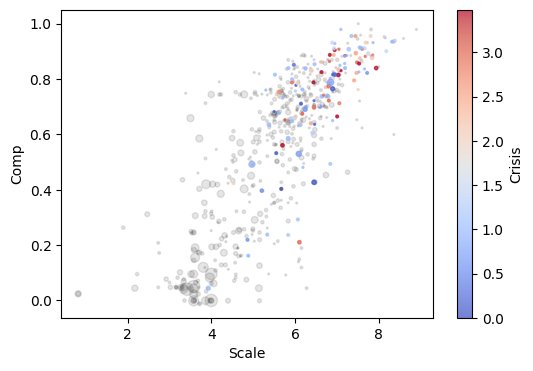

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))

gray_plot = dataset.scv_imputed[pd.isna(dataset.scv_imputed['predecessor_assassination'])]
gray_group = gray_plot.groupby('PolityName')
mean_inst_1 = gray_group['Comp'].mean()
mean_scale_1 = gray_group['Scale_1'].mean()
num_observations = gray_group.size()
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      c = 'black',
                      s=num_observations * 2,
                      alpha=0.1,
                      )

dataset_plot = dataset.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
polity_group = dataset.scv_imputed.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.5
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

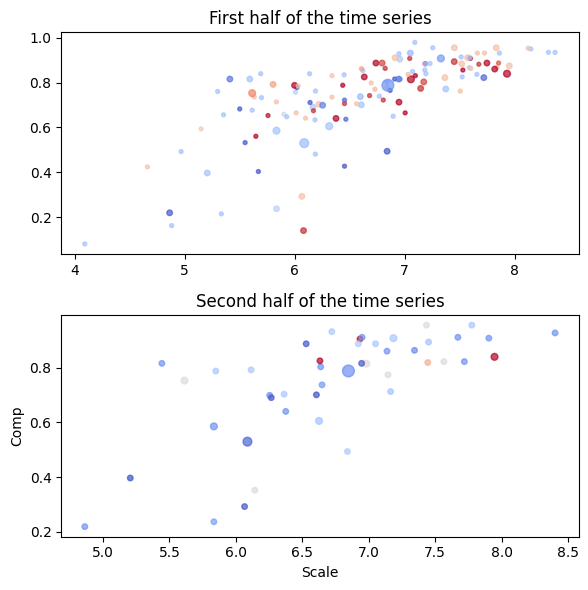

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(6, 6))

dataset_plot = dataset.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
polity_group = dataset_plot.groupby('PolityName')

# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
mean_scale_1 = polity_group['Scale_1'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
mean_crisis = polity_group['predecessor_assassination'].apply(lambda x: np.mean(x[:int(np.ceil(len(x)/2))]))
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.5
# Create a scatter plot
scatter = ax[0].scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 8,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )
ax[0].set_title('First half of the time series')
# Add a color bar
# ax[0].colorbar(scatter, label='Crisis')
# add name of polity on each bubble
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
mean_scale_1 = polity_group['Scale_1'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
mean_crisis = polity_group['predecessor_assassination'].apply(lambda x: np.mean(x[int(np.ceil(len(x)/2)):]))
num_observations = polity_group.size()


v_max = mean_crisis.max()*0.5
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 8,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
ax[1].set_title('Second half of the time series')
# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.tight_layout()
plt.show()